# JCC2 DC Format - Application Section Matrix Analysis

This notebook analyzes JCC2 data in DC (District of Columbia) format, which differs from the UQ (Utah) format in several ways:

## Key Differences between UQ and DC Formats:

### 1. Data Structure
- **UQ Format**: Rigid column structure with specific fields for each application/metric (e.g., `mop_1_1_1.intelligence_data_provided_jcc2cyberops`)
- **DC Format**: Flexible structure using JSON datatables within cells, with simpler column naming (e.g., `mop111.task_performance`)

### 2. Section Naming
- **UQ Format**: Uses underscores in section names (e.g., `mop_1_1_1`, `mos_1_1_2`)
- **DC Format**: Uses condensed naming without underscores (e.g., `mop111`, `mos112`)

### 3. Response Storage
- **UQ Format**: Direct values in cells
- **DC Format**: JSON objects containing structured data, especially for datatable fields

### 4. Basic Information Fields
- **UQ Format**: `user_information.event`, `user_information.unit`, `role_and_echelon.*`
- **DC Format**: `basic_info.participant_org`, `basic_info.date`, `basic_info.tester_name`

### 5. Application Lists
- **UQ Format**: Applications embedded in field names
- **DC Format**: Applications listed in `applications_used.*` fields and within datatables

In [1]:
# Add parent directory to path for imports
import sys
import os
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath('.'))))

# Import the data processor
from jcc2_data_processor import create_processor

In [2]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
import json
warnings.filterwarnings('ignore')

# Great Tables for beautiful output
from great_tables import GT, md, html, loc, style
from great_tables.data import exibble

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Load DC Format Data

In [3]:
# Load DC format data files
data_files = {
    "DCDC": "/home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/DCDC DC Combined_2025-08-05_pii_scrubbed_fixed.csv",
    "COGUARD": "/home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/COGUARD DC Combined_2025-08-05_pii_scrubbed_fixed.csv",
    "CNMF": "/home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/CNMF DC Combined_2025-08-05_pii_scrubbed_fixed.csv"
}

# Initialize processors and dataframes
processors = {}
dataframes = {}

for name, filepath in data_files.items():
    try:
        processors[name] = create_processor(filepath)
        dataframes[name] = processors[name].load_data()
        print(f"\n{name}:")
        print(f"  - Data loaded: {len(dataframes[name])} responses, {len(dataframes[name].columns)} fields")
        print(f"  - Format detected: {processors[name].format_type.value}")
        if 'basic_info.date' in dataframes[name].columns:
            print(f"  - Date range: {dataframes[name]['basic_info.date'].min()} to {dataframes[name]['basic_info.date'].max()}")
        print(f"  - Sections found: {len(processors[name].sections)}")
        for section, fields in list(processors[name].sections.items())[:3]:
            print(f"    {section}: {len(fields)} fields")
    except Exception as e:
        print(f"\nError loading {name}: {e}")

2025-08-05 15:30:51,613 - INFO - Detected Data Collection format
2025-08-05 15:30:51,614 - INFO - Loading data from /home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/DCDC DC Combined_2025-08-05_pii_scrubbed_fixed.csv
2025-08-05 15:30:51,619 - INFO - Parsing field schemas
2025-08-05 15:30:51,626 - INFO - Loaded 15 data rows with 376 columns
2025-08-05 15:30:51,626 - INFO - Found 39 sections and 6 system columns
2025-08-05 15:30:51,634 - INFO - Detected Data Collection format
2025-08-05 15:30:51,634 - INFO - Loading data from /home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/COGUARD DC Combined_2025-08-05_pii_scrubbed_fixed.csv
2025-08-05 15:30:51,638 - INFO - Parsing field schemas
2025-08-05 15:30:51,643 - INFO - Loaded 4 data rows with 376 columns
2025-08-05 15:30:51,645 - INFO - Found 39 sections and 6 system columns
2025-08-05 15:30:51,655 - INFO - Detected Data Collection format
2025-08-05 15:30:51,655 - INFO 


DCDC:
  - Data loaded: 15 responses, 376 fields
  - Format detected: data_collection
  - Date range: 2025-06-23 to 2025-07-23
  - Sections found: 39
    basic_info: 4 fields
    applications_used: 15 fields
    mop111: 10 fields

COGUARD:
  - Data loaded: 4 responses, 376 fields
  - Format detected: data_collection
  - Date range: 2025-06-30 to 2025-06-30
  - Sections found: 39
    basic_info: 4 fields
    applications_used: 15 fields
    mop111: 10 fields

CNMF:
  - Data loaded: 5 responses, 376 fields
  - Format detected: data_collection
  - Date range: 2025-06-26 to 2025-06-26
  - Sections found: 39
    basic_info: 4 fields
    applications_used: 15 fields
    mop111: 10 fields


## Define DC Format Sections and Applications Mapping

In [4]:
# DC Format Section Mappings
DC_SECTIONS = {
    "Intelligence & Situation Awareness": [
        "mop111",  # Intelligence data gathering
        "mos112",  # Object tagging and correlation
        "mop113",  # Operational status tracking
    ],
    "Reporting & Data Export": [
        "mop114",  # Reporting capabilities
        "mop115",  # Data export/import
        "mop216",  # Additional export/import
    ],
    "Threat Detection & Assessment": [
        "mop121",  # Threat detection
        "mop122",  # Threat assessment
    ],
    "Common Operating Picture": [
        "mos131",  # COP display
        "mop132",  # Dependency mapping
        "mop133",  # Event creation
        "mop134",  # Alerts
        "mop135",  # Data flow security
        "mop136",  # Additional COP features
    ],
    "Mission Planning & Management": [
        "mop211",  # Cyber force assessment
        "mop212",  # Target management
        "mop213",  # Mission editing
        "mop214",  # Collaborative mission planning
        "mop215",  # Mission data viewing
        "mop217",  # Force deconfliction
        "mop218",  # Mission access
        "mop219",  # Joint planning
        "mop2110", # Mission creation
    ],
    "Command & Control": [
        "mop221",  # Order creation
        "mop222",  # Order display
        "mop231",  # Mission status reporting
        "mop232",  # Force disposition
        "mop233",  # Mission tracking
        "mop234",  # Mission progress
        "mop241",  # Assessment tools
    ],
    "System Support & Training": [
        "mos311",  # System availability
        "mos312",  # Additional availability
        "mos321",  # Training
        "mos322",  # Documentation
        "mop323",  # Help desk support
    ],
}

# Applications commonly found in DC format data
DC_APPLICATIONS = [
    "A2IT", "CAD", "Codex", "Crucible", "Cyber 9-Line", 
    "Dispatch", "JCC2 Cyber-Ops", "JCC2 Readiness", 
    "MADSS", "Rally", "RedMap", "SigAct", 
    "Threat Hub", "Triage", "Unity"
]

## Analysis Functions for DC Format

In [5]:
def extract_application_from_datatable(datatable_value):
    """
    Extract application names from DC format datatable JSON
    """
    if pd.isna(datatable_value) or not datatable_value:
        return []
    
    applications = set()
    
    try:
        # If it's already a dict, use it directly
        if isinstance(datatable_value, dict):
            data = datatable_value
        else:
            # Try to parse as JSON
            data = json.loads(str(datatable_value))
        
        # Look for application names in rows
        if 'rows' in data:
            for row in data['rows']:
                if 'application_used' in row:
                    app = row['application_used']
                    if app and app != "":
                        applications.add(app)
    except:
        pass
    
    return list(applications)


def calculate_dc_field_rating(field_name, df, processor):
    """
    Calculate rating for a DC format field
    """
    if field_name not in df.columns:
        return 0.0
    
    # Get field schema
    field_schema = processor.schema.get(field_name)
    if not field_schema:
        return 0.0
    
    # For datatable fields, check if any rows exist
    if field_schema.field_type == 'datatable':
        valid_count = 0
        for val in df[field_name]:
            if isinstance(val, dict) and 'rows' in val and len(val['rows']) > 0:
                valid_count += 1
        return valid_count / len(df) if len(df) > 0 else 0.0
    
    # For task performance fields
    if 'task_performance' in field_name:
        value_counts = df[field_name].value_counts()
        yes_count = value_counts.get('Yes', 0)
        total_valid = sum(value_counts.get(val, 0) for val in ['Yes', 'N/A', 'No'])
        if total_valid > 0:
            # Score: Yes=1.0, N/A=0.5, No=0.0
            score = (yes_count * 1.0 + value_counts.get('N/A', 0) * 0.5) / total_valid
            return score
    
    # For other fields, use completion rate
    completion_rate = df[field_name].notna().mean()
    return completion_rate


def extract_applications_from_dc_data(df, processor):
    """
    Extract all applications mentioned in DC format data
    """
    applications = set()
    
    # Check applications_used fields
    for col in df.columns:
        if col.startswith('applications_used.'):
            # Count 'Yes' responses
            if (df[col] == 'Yes').any():
                # Extract app name from column name
                app_name = col.replace('applications_used.exp_app_', '')
                app_name = app_name.replace('_', ' ').title()
                applications.add(app_name)
    
    # Check datatable fields for applications
    for field_name, field_schema in processor.datatable_fields.items():
        for val in df[field_name].dropna():
            apps = extract_application_from_datatable(val)
            applications.update(apps)
    
    return sorted(list(applications))


def create_dc_rating_matrix(df, processor, dataset_name="Dataset"):
    """
    Create a rating matrix for DC format data
    """
    # Get applications from the data
    applications = extract_applications_from_dc_data(df, processor)
    
    # Initialize matrix
    matrix_data = []
    
    for section_name, section_codes in DC_SECTIONS.items():
        section_scores = {}
        
        for section_code in section_codes:
            # Get all fields for this section
            section_fields = [f for f in df.columns if f.startswith(f"{section_code}.")]
            
            if section_fields:
                # Calculate average rating for this section
                ratings = [calculate_dc_field_rating(field, df, processor) for field in section_fields]
                avg_rating = np.mean([r for r in ratings if r > 0]) if any(r > 0 for r in ratings) else 0.0
            else:
                avg_rating = 0.0
            
            section_scores[section_code] = avg_rating
        
        # Add row to matrix
        row = {
            'Section': section_name,
            'Dataset': dataset_name
        }
        
        # Add average score for the section
        all_scores = list(section_scores.values())
        row['Average'] = np.mean(all_scores) if all_scores else 0.0
        
        # Add individual section scores
        for code, score in section_scores.items():
            row[code] = score
        
        matrix_data.append(row)
    
    return pd.DataFrame(matrix_data)

## Create Rating Matrices for DC Data

In [6]:
# Create rating matrices for all datasets
print("Creating rating matrices for all datasets...")
matrices = {}

for name, df in dataframes.items():
    processor = processors[name]
    matrices[name] = create_dc_rating_matrix(df, processor, name)
    print(f"\n{name} Rating Matrix:")
    print(matrices[name])

Creating rating matrices for all datasets...

DCDC Rating Matrix:
                              Section Dataset   Average   mop111    mos112  \
0  Intelligence & Situation Awareness    DCDC  0.204656  0.17619  0.293333   
1             Reporting & Data Export    DCDC  0.238580      NaN       NaN   
2       Threat Detection & Assessment    DCDC  0.050000      NaN       NaN   
3            Common Operating Picture    DCDC  0.249700      NaN       NaN   
4       Mission Planning & Management    DCDC  0.211287      NaN       NaN   
5                   Command & Control    DCDC  0.229116      NaN       NaN   
6           System Support & Training    DCDC  0.436583      NaN       NaN   

     mop113    mop114    mop115    mop216  mop121  mop122    mos131    mop132  \
0  0.144444       NaN       NaN       NaN     NaN     NaN       NaN       NaN   
1       NaN  0.290741  0.358333  0.066667     NaN     NaN       NaN       NaN   
2       NaN       NaN       NaN       NaN     0.0     0.1       Na

## Visualize Rating Matrices

In [7]:
# Create a beautiful table using great_tables
def create_rating_table(matrix_df, title):
    """
    Create a formatted table using great_tables
    """
    # Get numeric columns (excluding Section and Dataset)
    numeric_cols = [col for col in matrix_df.columns if col not in ['Section', 'Dataset']]
    
    # Create the table
    gt_table = (
        GT(matrix_df)
        .tab_header(
            title=title,
            subtitle="Task completion and effectiveness ratings by section"
        )
        .fmt_number(
            columns=numeric_cols,
            decimals=2
        )
        .data_color(
            columns=numeric_cols,
            palette=["#FFF", "#90EE90", "#228B22"],
            domain=[0, 1],
            na_color="#F0F0F0"
        )
        .tab_style(
            style=style.text(weight="bold"),
            locations=loc.body(columns=["Section", "Average"])
        )
        .cols_width(
            {"Section": "200px", "Average": "80px"}
        )
    )
    
    return gt_table

# Create and display tables for all datasets
for name, matrix in matrices.items():
    table = create_rating_table(matrix, f"{name} Application Section Matrix")
    print(f"\n=== {name} Matrix ===")
    display(table)


=== DCDC Matrix ===


GT(_tbl_data=                              Section Dataset   Average   mop111    mos112  \
0  Intelligence & Situation Awareness    DCDC  0.204656  0.17619  0.293333   
1             Reporting & Data Export    DCDC  0.238580      NaN       NaN   
2       Threat Detection & Assessment    DCDC  0.050000      NaN       NaN   
3            Common Operating Picture    DCDC  0.249700      NaN       NaN   
4       Mission Planning & Management    DCDC  0.211287      NaN       NaN   
5                   Command & Control    DCDC  0.229116      NaN       NaN   
6           System Support & Training    DCDC  0.436583      NaN       NaN   

     mop113    mop114    mop115    mop216  mop121  mop122    mos131    mop132  \
0  0.144444       NaN       NaN       NaN     NaN     NaN       NaN       NaN   
1       NaN  0.290741  0.358333  0.066667     NaN     NaN       NaN       NaN   
2       NaN       NaN       NaN       NaN     0.0     0.1       NaN       NaN   
3       NaN       NaN       NaN       NaN     NaN     NaN  0.373333  0.238095   
4       NaN       NaN       NaN       NaN     NaN     NaN       NaN       NaN   
5       NaN       NaN       NaN       NaN     NaN     NaN       NaN       NaN   
6       NaN       NaN       NaN       NaN     NaN     NaN       NaN       NaN   

   mop133    mop134    mop135    mop136    mop211    mop212    mop213  \
0     NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1     NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2     NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3     0.3  0.185185  0.244444  0.157143       NaN       NaN       NaN   
4     NaN       NaN       NaN       NaN  0.266667  0.066667  0.255556   
5     NaN       NaN       NaN       NaN       NaN       NaN       NaN   
6     NaN       NaN       NaN       NaN       NaN       NaN       NaN   

     mop214  mop215    mop217  mop218    mop219   mop2110    mop221    mop222  \
0       NaN     NaN       NaN     NaN       NaN       NaN       NaN       NaN   
1       NaN     NaN       NaN     NaN       NaN       NaN       NaN       NaN   
2       NaN     NaN       NaN     NaN       NaN       NaN       NaN       NaN   
3       NaN     NaN       NaN     NaN       NaN       NaN       NaN       NaN   
4  0.247619     0.1  0.209524     0.3  0.233333  0.222222       NaN       NaN   
5       NaN     NaN       NaN     NaN       NaN       NaN  0.253333  0.306667   
6       NaN     NaN       NaN     NaN       NaN       NaN       NaN       NaN   

   mop231    mop232    mop233    mop234    mop241  mos311  mos312  mos321  \
0     NaN       NaN       NaN       NaN       NaN     NaN     NaN     NaN   
1     NaN       NaN       NaN       NaN       NaN     NaN     NaN     NaN   
2     NaN       NaN       NaN       NaN       NaN     NaN     NaN     NaN   
3     NaN       NaN       NaN       NaN       NaN     NaN     NaN     NaN   
4     NaN       NaN       NaN       NaN       NaN     NaN     NaN     NaN   
5     0.0  0.219048  0.238095  0.293333  0.293333     NaN     NaN     NaN   
6     NaN       NaN       NaN       NaN       NaN    0.32     0.0     0.8   

     mos322   mop323  
0       NaN      NaN  
1       NaN      NaN  
2       NaN      NaN  
3       NaN      NaN  
4       NaN      NaN  
5       NaN      NaN  
6  0.561905  0.50101  , _body=<great_tables._gt_data.Body object at 0x708e05a8d090>, _boxhead=Boxhead([ColInfo(var='Section', type=<ColInfoTypeEnum.default: 1>, column_label='Section', column_align='left', column_width='200px'), ColInfo(var='Dataset', type=<ColInfoTypeEnum.default: 1>, column_label='Dataset', column_align='left', column_width=None), ColInfo(var='Average', type=<ColInfoTypeEnum.default: 1>, column_label='Average', column_align='right', column_width='80px'), ColInfo(var='mop111', type=<ColInfoTypeEnum.default: 1>, column_label='mop111', column_align='right', column_width=None), ColInfo(var='mos112', type=<ColInfoTypeEnum.default: 1>, column_label='mos112', column_align='right',


=== COGUARD Matrix ===


GT(_tbl_data=                              Section  Dataset   Average  mop111  mos112  \
0  Intelligence & Situation Awareness  COGUARD  0.166667     0.0     0.5   
1             Reporting & Data Export  COGUARD  0.409722     NaN     NaN   
2       Threat Detection & Assessment  COGUARD  0.125000     NaN     NaN   
3            Common Operating Picture  COGUARD  0.353373     NaN     NaN   
4       Mission Planning & Management  COGUARD  0.326389     NaN     NaN   
5                   Command & Control  COGUARD  0.442857     NaN     NaN   
6           System Support & Training  COGUARD  0.510000     NaN     NaN   

   mop113  mop114    mop115  mop216  mop121  mop122    mos131  mop132  \
0     0.0     NaN       NaN     NaN     NaN     NaN       NaN     NaN   
1     NaN   0.375  0.541667  0.3125     NaN     NaN       NaN     NaN   
2     NaN     NaN       NaN     NaN    0.25     0.0       NaN     NaN   
3     NaN     NaN       NaN     NaN     NaN     NaN  0.916667     0.0   
4     NaN     NaN       NaN     NaN     NaN     NaN       NaN     NaN   
5     NaN     NaN       NaN     NaN     NaN     NaN       NaN     NaN   
6     NaN     NaN       NaN     NaN     NaN     NaN       NaN     NaN   

     mop133  mop134  mop135  mop136  mop211  mop212  mop213    mop214  mop215  \
0       NaN     NaN     NaN     NaN     NaN     NaN     NaN       NaN     NaN   
1       NaN     NaN     NaN     NaN     NaN     NaN     NaN       NaN     NaN   
2       NaN     NaN     NaN     NaN     NaN     NaN     NaN       NaN     NaN   
3  0.428571     0.4   0.375     0.0     NaN     NaN     NaN       NaN     NaN   
4       NaN     NaN     NaN     NaN  0.4375     0.0   0.375  0.541667    0.25   
5       NaN     NaN     NaN     NaN     NaN     NaN     NaN       NaN     NaN   
6       NaN     NaN     NaN     NaN     NaN     NaN     NaN       NaN     NaN   

   mop217  mop218    mop219  mop2110    mop221    mop222  mop231  mop232  \
0     NaN     NaN       NaN      NaN       NaN       NaN     NaN     NaN   
1     NaN     NaN       NaN      NaN       NaN       NaN     NaN     NaN   
2     NaN     NaN       NaN      NaN       NaN       NaN     NaN     NaN   
3     NaN     NaN       NaN      NaN       NaN       NaN     NaN     NaN   
4    0.25   0.375  0.458333     0.25       NaN       NaN     NaN     NaN   
5     NaN     NaN       NaN      NaN  0.458333  0.583333     0.0     0.6   
6     NaN     NaN       NaN      NaN       NaN       NaN     NaN     NaN   

     mop233  mop234  mop241  mos311  mos312  mos321  mos322  mop323  
0       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
1       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
3       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
4       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
5  0.458333     0.5     0.5     NaN     NaN     NaN     NaN     NaN  
6       NaN     NaN     NaN     0.4     0.0    0.75    0.65    0.75  , _body=<great_tables._gt_data.Body object at 0x708e05a966d0>, _boxhead=Boxhead([ColInfo(var='Section', type=<ColInfoTypeEnum.default: 1>, column_label='Section', column_align='left', column_width='200px'), ColInfo(var='Dataset', type=<ColInfoTypeEnum.default: 1>, column_label='Dataset', column_align='left', column_width=None), ColInfo(var='Average', type=<ColInfoTypeEnum.default: 1>, column_label='Average', column_align='right', column_width='80px'), ColInfo(var='mop111', type=<ColInfoTypeEnum.default: 1>, column_label='mop111', column_align='right', column_width=None), ColInfo(var='mos112', type=<ColInfoTypeEnum.default: 1>, column_label='mos112', column_align='right', column_width=None), ColInfo(var='mop113', type=<ColInfoTypeEnum.default: 1>, column_label='mop113', column_align='right', column_width=None), ColInfo(var='mop114', type=<ColInfoTypeEnum.default: 1>, column_label='mop114', column_align='right', column_width=None), ColInfo(var='mop115', type=<ColI


=== CNMF Matrix ===


GT(_tbl_data=                              Section Dataset   Average  mop111  mos112  \
0  Intelligence & Situation Awareness    CNMF  0.000000     0.0     0.0   
1             Reporting & Data Export    CNMF  0.120000     NaN     NaN   
2       Threat Detection & Assessment    CNMF  0.000000     NaN     NaN   
3            Common Operating Picture    CNMF  0.185185     NaN     NaN   
4       Mission Planning & Management    CNMF  0.555450     NaN     NaN   
5                   Command & Control    CNMF  0.481542     NaN     NaN   
6           System Support & Training    CNMF  0.476952     NaN     NaN   

   mop113  mop114  mop115  mop216  mop121  mop122    mos131  mop132  mop133  \
0     0.0     NaN     NaN     NaN     NaN     NaN       NaN     NaN     NaN   
1     NaN     0.0     0.0    0.36     NaN     NaN       NaN     NaN     NaN   
2     NaN     NaN     NaN     NaN     0.0     0.0       NaN     NaN     NaN   
3     NaN     NaN     NaN     NaN     NaN     NaN  0.711111     0.0     0.0   
4     NaN     NaN     NaN     NaN     NaN     NaN       NaN     NaN     NaN   
5     NaN     NaN     NaN     NaN     NaN     NaN       NaN     NaN     NaN   
6     NaN     NaN     NaN     NaN     NaN     NaN       NaN     NaN     NaN   

   mop134  mop135  mop136  mop211    mop212    mop213  mop214  mop215  mop217  \
0     NaN     NaN     NaN     NaN       NaN       NaN     NaN     NaN     NaN   
1     NaN     NaN     NaN     NaN       NaN       NaN     NaN     NaN     NaN   
2     NaN     NaN     NaN     NaN       NaN       NaN     NaN     NaN     NaN   
3     0.0     0.4     0.0     NaN       NaN       NaN     NaN     NaN     NaN   
4     NaN     NaN     NaN    0.48  0.441667  0.416667     0.6     0.5   0.475   
5     NaN     NaN     NaN     NaN       NaN       NaN     NaN     NaN     NaN   
6     NaN     NaN     NaN     NaN       NaN       NaN     NaN     NaN     NaN   

     mop218    mop219   mop2110  mop221  mop222  mop231    mop232    mop233  \
0       NaN       NaN       NaN     NaN     NaN     NaN       NaN       NaN   
1       NaN       NaN       NaN     NaN     NaN     NaN       NaN       NaN   
2       NaN       NaN       NaN     NaN     NaN     NaN       NaN       NaN   
3       NaN       NaN       NaN     NaN     NaN     NaN       NaN       NaN   
4  0.666667  0.933333  0.485714     NaN     NaN     NaN       NaN       NaN   
5       NaN       NaN       NaN     0.4    0.72     0.0  0.488889  0.714286   
6       NaN       NaN       NaN     NaN     NaN     NaN       NaN       NaN   

     mop234    mop241  mos311  mos312    mos321  mos322    mop323  
0       NaN       NaN     NaN     NaN       NaN     NaN       NaN  
1       NaN       NaN     NaN     NaN       NaN     NaN       NaN  
2       NaN       NaN     NaN     NaN       NaN     NaN       NaN  
3       NaN       NaN     NaN     NaN       NaN     NaN       NaN  
4       NaN       NaN     NaN     NaN       NaN     NaN       NaN  
5  0.533333  0.514286     NaN     NaN       NaN     NaN       NaN  
6       NaN       NaN    0.48     0.0  0.771429     0.6  0.533333  , _body=<great_tables._gt_data.Body object at 0x708e05a8c490>, _boxhead=Boxhead([ColInfo(var='Section', type=<ColInfoTypeEnum.default: 1>, column_label='Section', column_align='left', column_width='200px'), ColInfo(var='Dataset', type=<ColInfoTypeEnum.default: 1>, column_label='Dataset', column_align='left', column_width=None), ColInfo(var='Average', type=<ColInfoTypeEnum.default: 1>, column_label='Average', column_align='right', column_width='80px'), ColInfo(var='mop111', type=<ColInfoTypeEnum.default: 1>, column_label='mop111', column_align='right', column_width=None), ColInfo(var='mos112', type=<ColInfoTypeEnum.default: 1>, column_label='mos112', column_align='right', column_width=None), ColInfo(var='mop113', type=<ColInfoTypeEnum.default: 1>, column_label='mop113', column_align='right', column_width=None), ColInfo(var='mop114', type=<ColInfoTypeEnum.default: 1>, column_label='mop114', column_align='right', colu

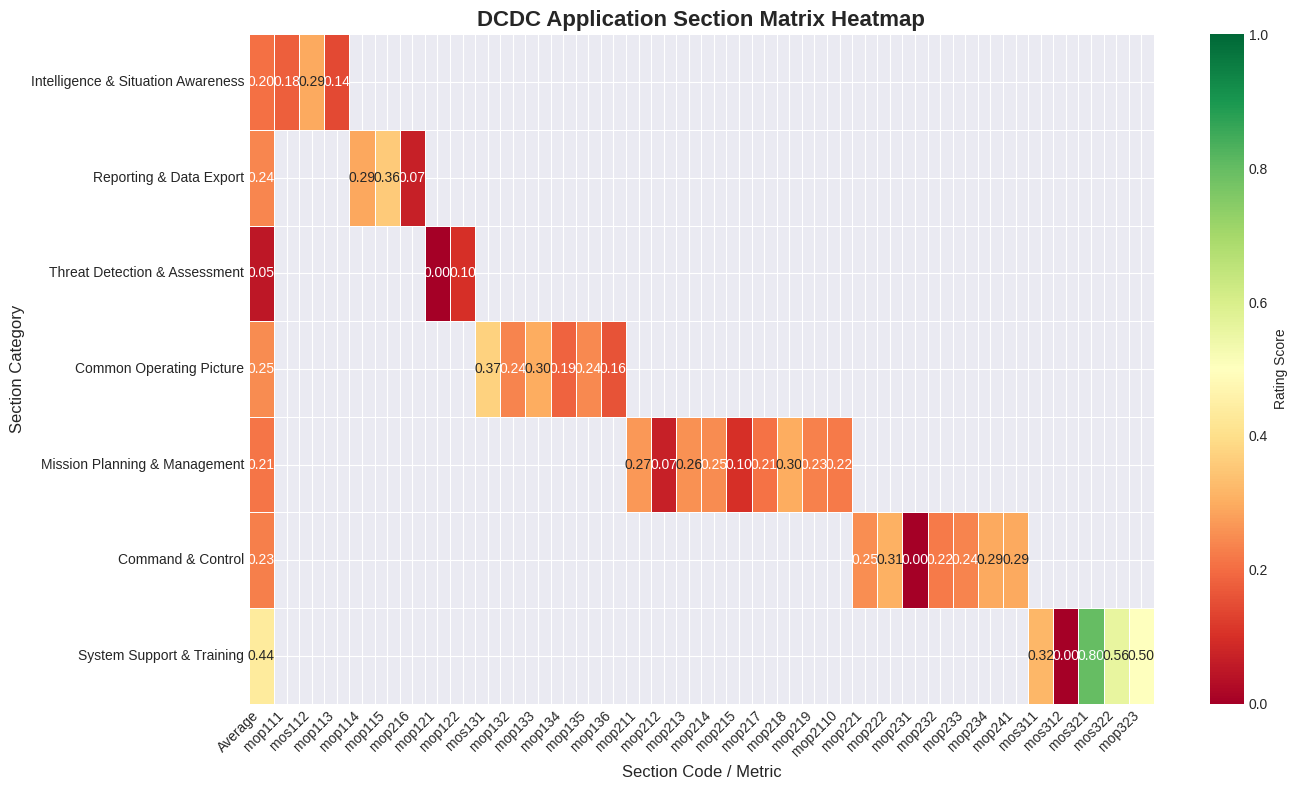

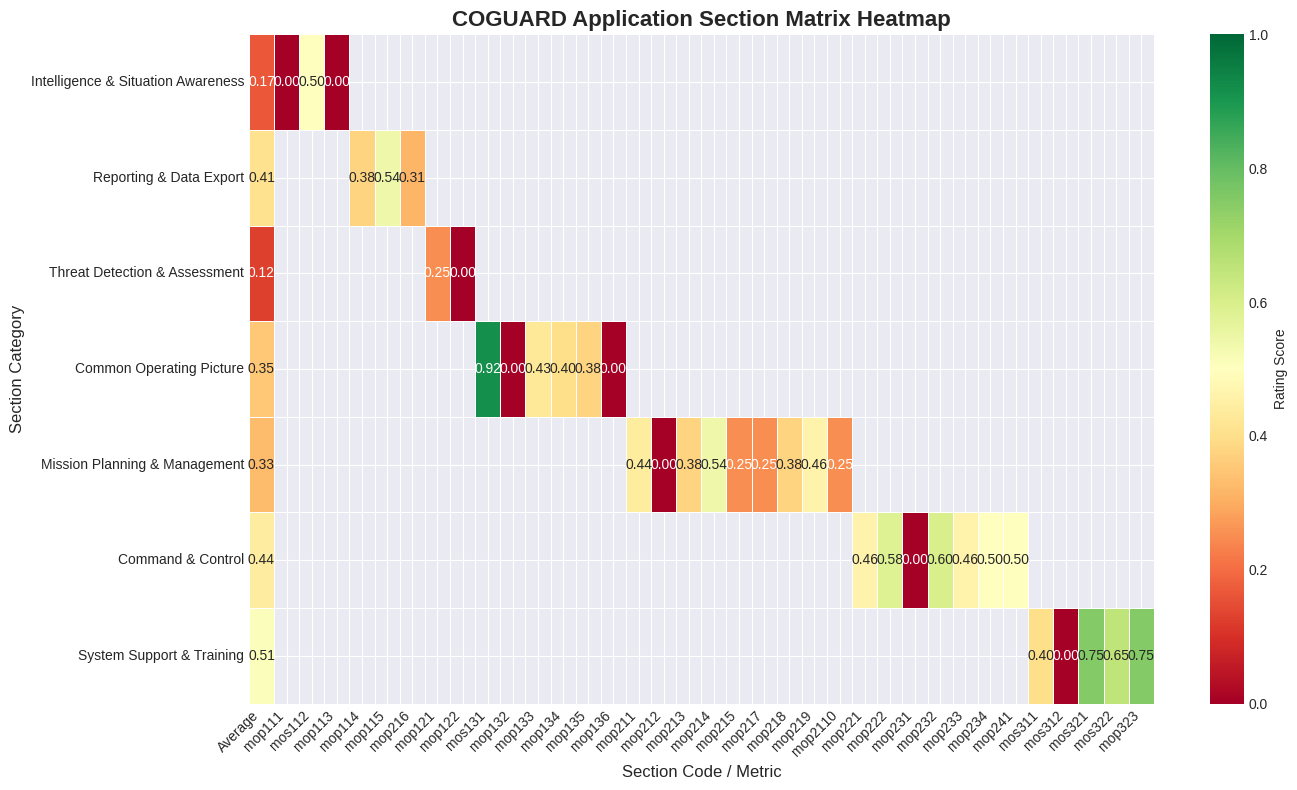

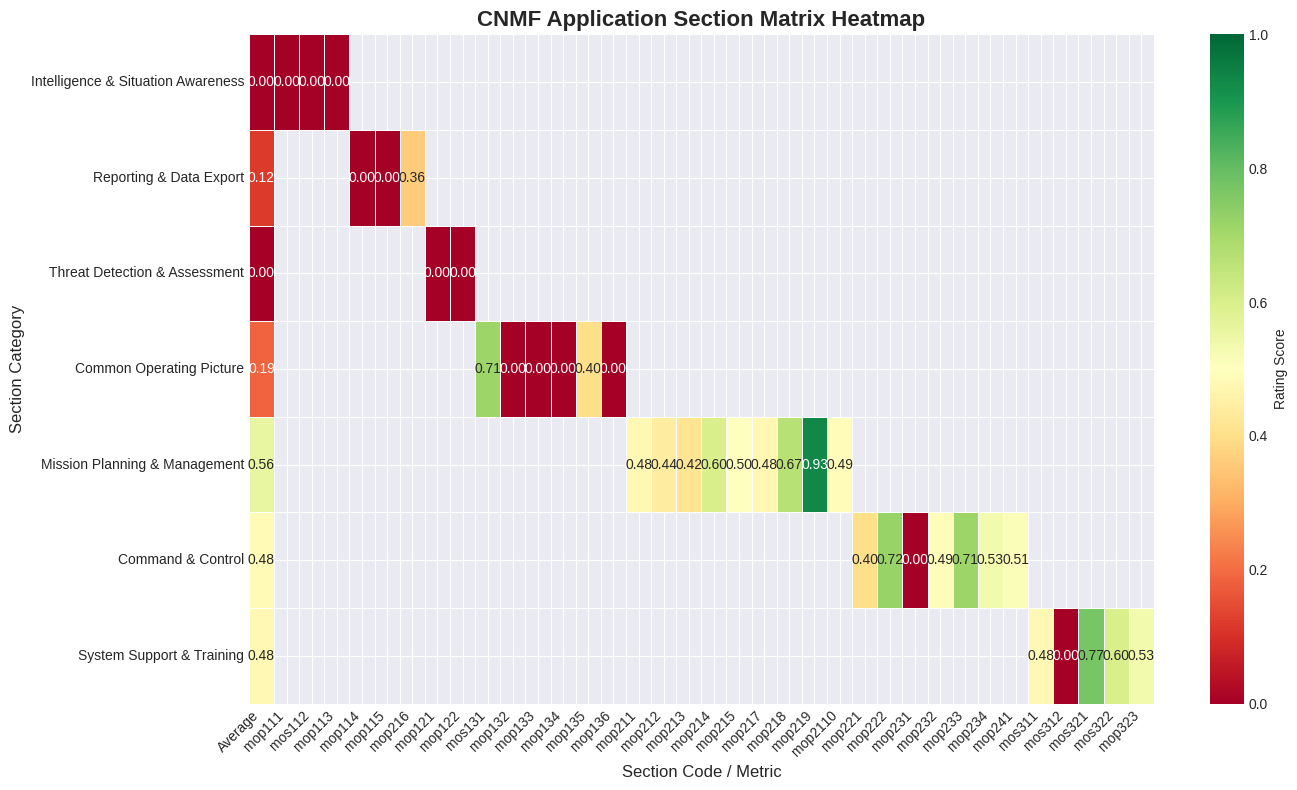

In [8]:
# Create heatmap visualizations
def create_heatmap(matrix_df, title):
    # Prepare data for heatmap (exclude non-numeric columns)
    heatmap_data = matrix_df.set_index('Section')
    heatmap_data = heatmap_data.drop(columns=['Dataset'], errors='ignore')
    
    # Create figure
    plt.figure(figsize=(14, 8))
    
    # Create heatmap
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt='.2f',
        cmap='RdYlGn',
        vmin=0,
        vmax=1,
        cbar_kws={'label': 'Rating Score'},
        linewidths=0.5
    )
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Section Code / Metric', fontsize=12)
    plt.ylabel('Section Category', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Create heatmaps for all datasets
for name, matrix in matrices.items():
    create_heatmap(matrix, f"{name} Application Section Matrix Heatmap")

## Compare DCDC and COGUARD Results

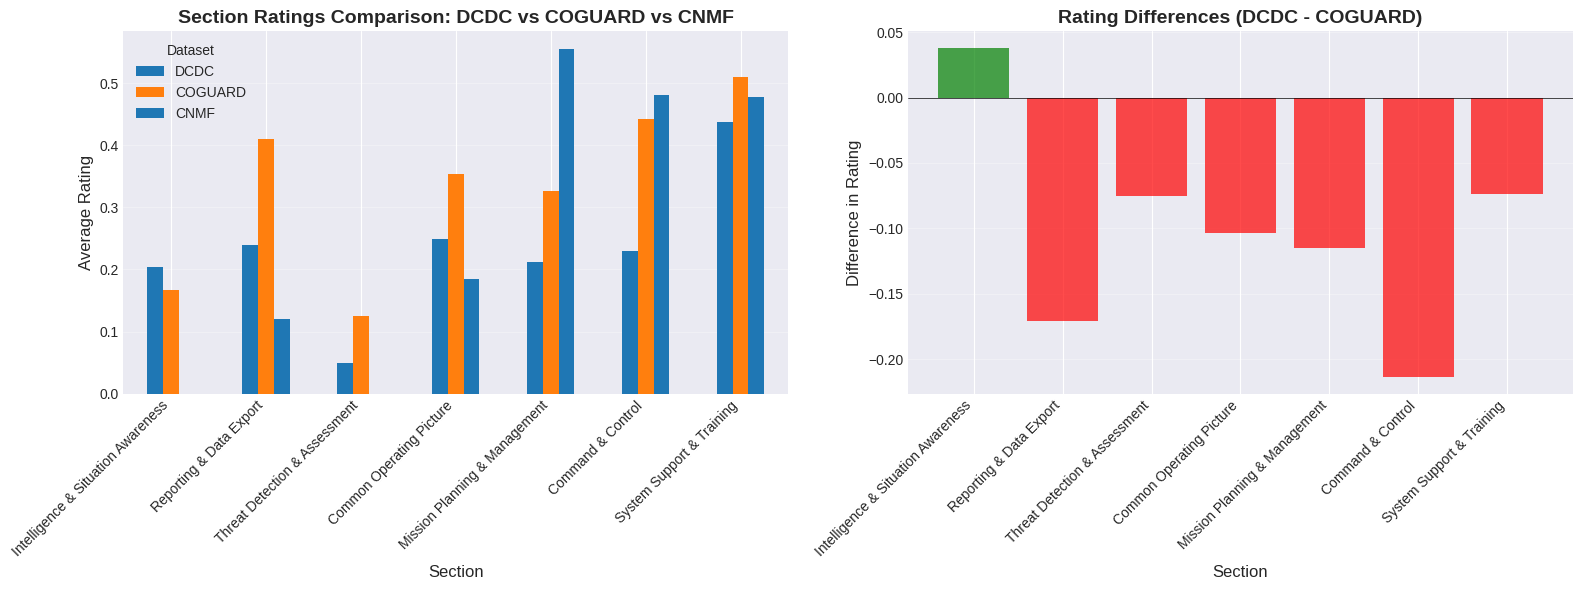


Detailed Comparison:
                           Section  DCDC  COGUARD  CNMF  Difference
Intelligence & Situation Awareness 0.205    0.167 0.000       0.038
           Reporting & Data Export 0.239    0.410 0.120      -0.171
     Threat Detection & Assessment 0.050    0.125 0.000      -0.075
          Common Operating Picture 0.250    0.353 0.185      -0.104
     Mission Planning & Management 0.211    0.326 0.555      -0.115
                 Command & Control 0.229    0.443 0.482      -0.214
         System Support & Training 0.437    0.510 0.477      -0.073


In [9]:
# Compare average ratings between datasets
if len(matrices) >= 2:
    comparison_data = []
    dataset_names = list(matrices.keys())
    
    for section in DC_SECTIONS.keys():
        row = {'Section': section}
        for name in dataset_names:
            row[name] = matrices[name][matrices[name]['Section'] == section]['Average'].values[0]
        
        # Calculate differences between first two datasets
        if len(dataset_names) >= 2:
            row['Difference'] = row[dataset_names[0]] - row[dataset_names[1]]
        
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Create comparison visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar plot comparison
    comparison_df.set_index('Section')[dataset_names].plot(
        kind='bar',
        ax=ax1,
        color=['#1f77b4', '#ff7f0e']
    )
    ax1.set_title(f'Section Ratings Comparison: {" vs ".join(dataset_names)}', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Average Rating', fontsize=12)
    ax1.set_xlabel('Section', fontsize=12)
    ax1.legend(title='Dataset')
    ax1.grid(axis='y', alpha=0.3)
    
    # Difference plot (if we have exactly 2 datasets)
    if 'Difference' in comparison_df.columns:
        colors = ['green' if x > 0 else 'red' for x in comparison_df['Difference']]
        ax2.bar(comparison_df['Section'], comparison_df['Difference'], color=colors, alpha=0.7)
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax2.set_title(f'Rating Differences ({dataset_names[0]} - {dataset_names[1]})', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Difference in Rating', fontsize=12)
        ax2.set_xlabel('Section', fontsize=12)
        ax2.grid(axis='y', alpha=0.3)
    
    # Rotate x labels
    for ax in [ax1, ax2]:
        ax.tick_params(axis='x', rotation=45)
        labels = ax.get_xticklabels()
        for label in labels:
            label.set_ha('right')
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison table
    print("\nDetailed Comparison:")
    print(comparison_df.to_string(index=False, float_format=lambda x: f'{x:.3f}'))
else:
    print("Need at least 2 datasets for comparison")

## Summary Statistics

In [10]:
# Calculate summary statistics
print("=== Summary Statistics ===")

# Applications found across datasets
all_applications = {}

for name, df in dataframes.items():
    processor = processors[name]
    
    print(f"\n{name} Dataset:")
    print(f"  Total responses: {len(df)}")
    
    matrix = matrices[name]
    print(f"  Overall average rating: {matrix['Average'].mean():.3f}")
    print(f"  Highest rated section: {matrix.loc[matrix['Average'].idxmax(), 'Section']} ({matrix['Average'].max():.3f})")
    print(f"  Lowest rated section: {matrix.loc[matrix['Average'].idxmin(), 'Section']} ({matrix['Average'].min():.3f})")
    
    # Extract applications
    apps = extract_applications_from_dc_data(df, processor)
    all_applications[name] = apps
    print(f"  Applications found ({len(apps)}): {', '.join(apps)}")

# Analyze application overlap
if len(all_applications) >= 2:
    print("\n=== Application Analysis ===")
    
    # Find common applications
    all_apps_sets = [set(apps) for apps in all_applications.values()]
    common_apps = set.intersection(*all_apps_sets)
    print(f"\nCommon Applications ({len(common_apps)}): {', '.join(sorted(common_apps))}")
    
    # Find unique applications per dataset
    for name, apps in all_applications.items():
        unique_apps = set(apps) - common_apps
        if unique_apps:
            print(f"{name} Only: {', '.join(sorted(unique_apps))}")

=== Summary Statistics ===

DCDC Dataset:
  Total responses: 15
  Overall average rating: 0.231
  Highest rated section: System Support & Training (0.437)
  Lowest rated section: Threat Detection & Assessment (0.050)
  Applications found (15): A2IT, A2It, Codex, JCC2 Cyber-Ops, JCC2 Readiness, Jcc2Cyberops, Jcc2Readiness, MADSS, Madss, Rally, SigAct, Sigact, Threat Hub, Threathub, Unity

COGUARD Dataset:
  Total responses: 4
  Overall average rating: 0.333
  Highest rated section: System Support & Training (0.510)
  Lowest rated section: Threat Detection & Assessment (0.125)
  Applications found (7): JCC2 Cyber-Ops, JCC2 Readiness, Jcc2Cyberops, Jcc2Readiness, Rally, SigAct, Sigact

CNMF Dataset:
  Total responses: 5
  Overall average rating: 0.260
  Highest rated section: Mission Planning & Management (0.555)
  Lowest rated section: Intelligence & Situation Awareness (0.000)
  Applications found (4): JCC2 Cyber-Ops, JCC2 Readiness, Jcc2Cyberops, Jcc2Readiness

=== Application Analysis

## Export Results

In [11]:
# Export matrices to CSV
output_dir = Path("jcc2_dc_matrix_analysis_output")
output_dir.mkdir(exist_ok=True)

# Export individual matrices
for name, matrix in matrices.items():
    matrix.to_csv(output_dir / f"{name.lower()}_dc_rating_matrix.csv", index=False)
    print(f"Exported {name} matrix to {name.lower()}_dc_rating_matrix.csv")

# Export comparison if we have multiple datasets
if len(matrices) >= 2 and 'comparison_df' in locals():
    comparison_df.to_csv(output_dir / "dc_format_comparison.csv", index=False)
    print("Exported comparison to dc_format_comparison.csv")

# Create combined summary
summary_data = {
    'Metadata': {
        'Generated': datetime.now().isoformat(),
        'Data_files': data_files,
        'Total_datasets': len(dataframes),
        'Responses_per_dataset': {name: len(df) for name, df in dataframes.items()}
    },
    'Overall_Ratings': {
        name: float(matrices[name]['Average'].mean()) 
        for name in matrices
    },
    'Applications': all_applications
}

# Add section comparisons if available
if 'comparison_df' in locals():
    summary_data['Section_Comparisons'] = comparison_df.to_dict('records')

# Add common/unique applications if we have multiple datasets
if len(all_applications) >= 2:
    all_apps_sets = [set(apps) for apps in all_applications.values()]
    common_apps = set.intersection(*all_apps_sets)
    summary_data['Applications']['Common'] = sorted(list(common_apps))
    
    for name, apps in all_applications.items():
        unique_apps = set(apps) - common_apps
        if unique_apps:
            summary_data['Applications'][f'{name}_only'] = sorted(list(unique_apps))

# Save summary JSON
with open(output_dir / "dc_format_analysis_summary.json", 'w') as f:
    json.dump(summary_data, f, indent=2)

print(f"\nResults exported to {output_dir}")
print("Files created:")
for name in matrices:
    print(f"  - {name.lower()}_dc_rating_matrix.csv")
if 'comparison_df' in locals():
    print("  - dc_format_comparison.csv")
print("  - dc_format_analysis_summary.json")

Exported DCDC matrix to dcdc_dc_rating_matrix.csv
Exported COGUARD matrix to coguard_dc_rating_matrix.csv
Exported CNMF matrix to cnmf_dc_rating_matrix.csv
Exported comparison to dc_format_comparison.csv


RuntimeError: dictionary changed size during iteration